In [1]:
%load_ext sql
%sql mysql+pymysql://root@localhost/myemployees

'Connected: root@myemployees'

# 事务

事务:事务由单独单元的一个或多个SQL语句组成，在这个单元中，每个MySQL语句是相互依赖的。而整个单独单元作为一个不可分割的整体，如果单元中某条SQL语句一旦执行失败或产生错误，整个单元将会回滚。所有受到影响的数据将返回到事物开始以前的状态;如果单元中的所有SQL语句均执行成功，则事物被顺利执行。(可以简单地理解为事务的sql操作先是在内存中"打草稿", 事务中的sql全部正确那么才会真正去执行所有的sql语句，在打草稿的演练过程中一旦发现有哪条语句执行失败所有的sql语句都不会真正执行)。

通过show engines;来查看mysql支持的存储引擎。

在mysql中用的最多的存储引擎有:innodb， myisam ,memory 等。其中innodb支持事务，而 myisam、memory等不支持事务

In [3]:
%sql show engines;

 * mysql+pymysql://root@localhost/myemployees
9 rows affected.


[('ARCHIVE', 'YES', 'Archive storage engine', 'NO', 'NO', 'NO'),
 ('BLACKHOLE', 'YES', '/dev/null storage engine (anything you write to it disappears)', 'NO', 'NO', 'NO'),
 ('MRG_MYISAM', 'YES', 'Collection of identical MyISAM tables', 'NO', 'NO', 'NO'),
 ('FEDERATED', 'NO', 'Federated MySQL storage engine', None, None, None),
 ('MyISAM', 'YES', 'MyISAM storage engine', 'NO', 'NO', 'NO'),
 ('PERFORMANCE_SCHEMA', 'YES', 'Performance Schema', 'NO', 'NO', 'NO'),
 ('InnoDB', 'DEFAULT', 'Supports transactions, row-level locking, and foreign keys', 'YES', 'YES', 'YES'),
 ('MEMORY', 'YES', 'Hash based, stored in memory, useful for temporary tables', 'NO', 'NO', 'NO'),
 ('CSV', 'YES', 'CSV storage engine', 'NO', 'NO', 'NO')]

# ACID

事务的ACID(acid)属性
1. 原子性(Atomicity)：
   原子性是指事务是一个不可分割的工作单位，事务中的操作要么
   都发生，要么都不发生。
2. 一致性(Consistency)：事务必须使数据库从一个一致性状态变换到另外一个一致性状态。一致性更多的是从现实世界的角度去看的。比如A有1000元,B有1000元，总共有2000元，一致性是说A转500给B，那么A是500，B是1500，两者和还是2000. 如果A是500，B还是1000，那么总共1500，丢失的500去哪了？这就不符合一致性。
3. 隔离性(Isolation)： 事务的隔离性是指一个事务的执行不能被其他事务干扰，即一个事务内部的操作及使用的数据对并发的其他事务是隔离的，并发执行的各个事务之间不能互相干扰。隔离级别不同，这里的隔离性也就不同。事务比较重要的就是这里的隔离性
4. 持久性(Durability) ：持久性是指一个事务一旦被提交，它对数据库中数据的改变就是永久性的，接下来的其他操作和数据库故障不应该对其有任何影 响。比如说删除一条数据，一旦commit了，那么数据就被删了，无法恢复(正常情况是这样，当然也可以通过一些备份机制去恢复)


## 隔离级别

对于同时运行的多个事务, 当这些事务访问数据库中相同的数据时, 如果没有采取必要的隔离机制, 就会导致各种并发问题:
* 脏读: 对于两个事务 T1, T2, T1 读取了已经被 T2 更新但还没有被提交的字段. 之后, 若 T2 回滚, T1读取的内容就是临时且无效的.(只读一次，读到是脏的数据)
* 不可重复读: 对于两个事务T1, T2, T1 读取了一个字段, 然后 T2 更新了该字段. 之后, T1再次读取同一个字段, 值就不同了.(重复读2次，读取的结果不一致)
* 幻读: 对于两个事务T1, T2, T1 从一个表中读取了一个字段, 然后 T2 在该表中插 入了一些新的行. 之后, 如果 T1 再次读取同一个表, 就会多出几行.(重复读2次，读取的记录的数目不一致)

数据库事务的隔离性: 数据库系统必须具有隔离并发运行各个事务的能力, 使它们不会相互影响, 避免各种并发问题.

一个事务与其他事务隔离的程度称为隔离级别. 数据库规定了多种事务隔离级别, 不同隔离级别对应不同的干扰程度, 隔离级别越高, 数据一致性就越好, 但并发性越弱.

数据库提供的 4 种事务隔离级别:

|事务隔离级别|	脏读|	不可重复读	|幻读|
|---|---|---|---|
|读未提交（read-uncommitted）|	是	|是	|是|
|不可重复读（read-committed）|	否	|是	|是|
|可重复读（repeatable-read）|	否	|否	|是|
|串行化（serializable）|	否|	否	|否|

从上面的表格可以看出，read-uncommitted是最垃圾的隔离级别，连脏读都无法解决，read-committed只是在上一个的基础上解决了脏读，但是无法解决不可重复读的问题，repeatable-read在上一个的基础上解决了不可重复读问题，serializable一般不用，并发效率太低了。只要控制好我们的业务代码，repeatable-read一般就能满足我们的业务需求了。

Mysql支持4种事务隔离级别. Mysql 默认的事务隔离级别为: REPEATABLE READ.

In [5]:
%sql select version();

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


[('8.0.15',)]

查看隔离级别：老版本mysql用的是tx_isolation，由于我装的是Mysql8，所以现在更名为 transaction_isolation.

每启动一个 mysql 程序, 就会获得一个单独的数据库连接. 每个数据库连接都有一个全局变量 @@transaction_isolation, 表示当前的事务隔离级别.
* 查看当前的隔离级别: SELECT @@transaction_isolation;
* 设置当前 mySQL 连接的隔离级别:
* set session transaction isolation level read committed;
* 设置数据库系统的全局的隔离级别:
* set global transaction isolation level read committed;

In [7]:
%sql SELECT @@transaction_isolation;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


[('REPEATABLE-READ',)]

## 事务的使用

在mysql中，把事务分为隐式事务和显式事务
1. 隐式事务：事务没有明显的开启和结束的标记，比如insert、update、delete语句(每条语句就是单独的一个事务, 自动commit)
2. 显式事务：事务具有明显的开启和结束的标记：前提：必须先设置自动提交功能为禁用(set autocommit=0;)



显式事务的使用步骤：
```
步骤1：开启事务
set autocommit=0;
start transaction; 或begin;  #可选的(有了set autocommit=0;这一句可以忽略)

步骤2：编写事务中的sql语句(select insert update delete)
语句1;
语句2;
...


步骤3：结束事务
commit;提交事务 或 rollback;回滚事务
```


In [8]:
%sql create table account (name varchar(10), balance int not null);  
%sql insert into account values ("张三", 1000), ("李四", 10000), ("王五", "1000");

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.
 * mysql+pymysql://root@localhost/myemployees
3 rows affected.


[]

### 读未提交

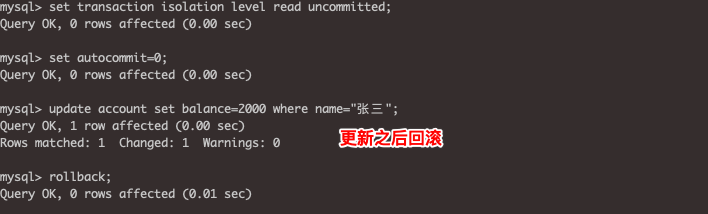

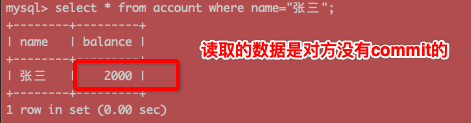

### 读已提交

避免脏读，但是无法避免可重复度

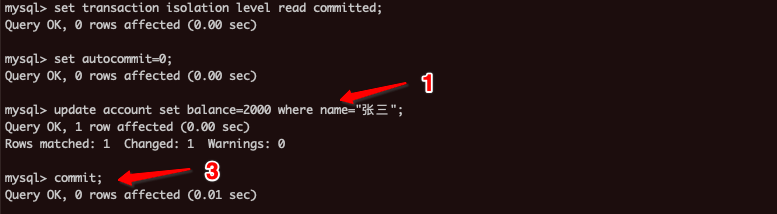

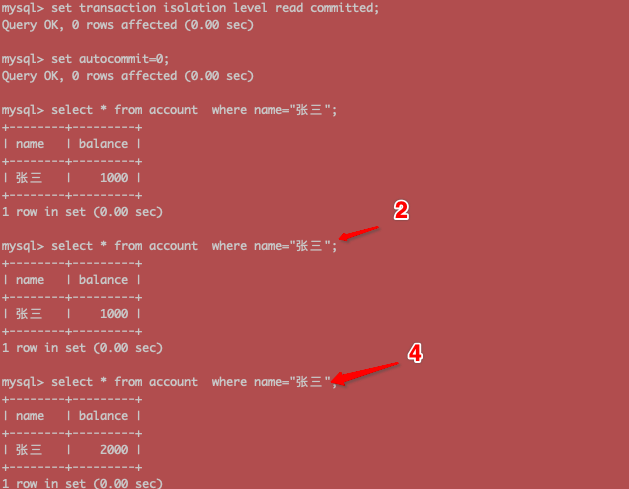

### 可重复读

解决不可重复读和脏读，但是无法解决幻读。

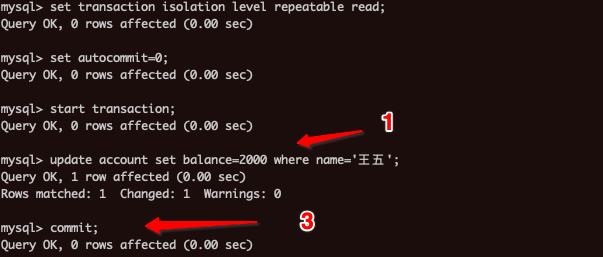

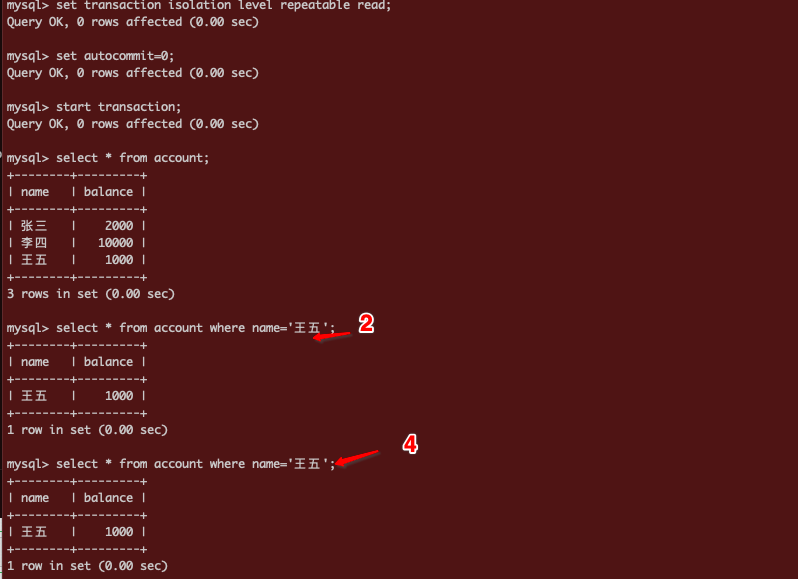

在暗红色终端发现读2次读取的内容一致，说明解决不可重复读问题。

#### 幻读

之前我对幻读的理解：说幻读是 事务A 执行两次 select 操作得到不同的数据集，即 select 1 得到 10 条记录，select 2 得到 11 条记录。这其实并不是幻读，当时我说这从表现形式上来说应该是不可重复读呀，当时只能强行告诉自己这种现象叫幻读。后来实际生产中，确确实实碰到幻读的现象，此时对幻读的理解如下：幻读侧重的方面是某一次的 select 操作得到的结果所表征的数据状态无法支撑后续的业务操作。更为具体一些：select 某记录是否存在，不存在，准备插入此记录，但执行 insert 时发现此记录已存在，无法插入，此时就发生了幻读。

In [ ]:
# 给name加 unique 唯一索引
%sql alter table account modify column name varchar(10) unique;

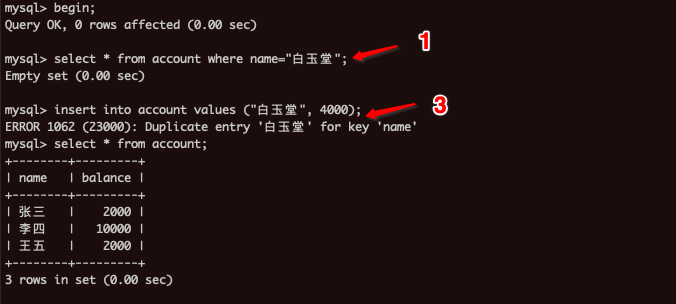

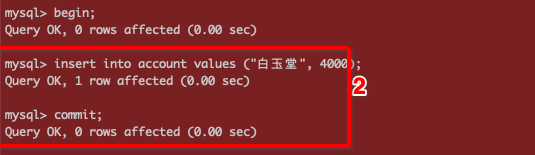

在黑色终端中，我第一次没查到"白玉堂", 所以我插入，发现插不进，说已经有白玉堂这个名字了，我再查一遍发现没有白玉堂这个名字呀，奇怪，难道我产生幻觉了？这是幻读比较合理的解释。

其实REPEATABLE-READ的隔离级别是可以避免幻读的，通过对 select 操作手动加行X锁（SELECT ... FOR UPDATE 这也正是 SERIALIZABLE 隔离级别下会隐式为你做的事情），同时还需要知道，即便当前记录不存在，比如 id = 1 是不存在的，当前事务也会获得一把记录锁（因为InnoDB的行锁锁定的是索引，故记录实体存在与否没关系，存在就加行排他锁，不存在就加 next-key lock间隙X锁。换言之，如果 id = 1 的记录存在则会被加行（X）锁，如果不存在，则会加 next-lock key / gap 锁（范围行锁，一样的），即记录存在与否，mysql 都会对记录应该对应的索引加锁，其他事务是无法再获得做操作的。），其他事务则无法插入此索引的记录，故杜绝了幻读。

InnoDB的行锁锁定的是索引，而不是记录本身，这一点也需要有清晰的认识，故某索引相同的记录都会被加锁，会造成索引竞争，这就需要我们严格设计业务sql，尽可能的使用主键或唯一索引对记录加锁。索引映射的记录如果存在，加行锁，如果不存在，则会加 next-key lock / gap 锁 / 间隙锁，故InnoDB可以实现事务对某记录的预先占用，如果记录存在，它就是本事务的，如果记录不存在，那它也将是本是无的，只要本是无还在，其他事务就别想占有它。

# 锁

官话：锁是计算机协调多个进程或线程并发访问某一资源的机制。锁保证数据并发访问的一致性、有效性；锁冲突也是影响数据库并发访问性能的一个重要因素。锁是Mysql在服务器层和存储引擎层的的并发控制。加锁是消耗资源的，锁的各种操作，包括获得锁、检测锁是否是否已解除、释放锁等。

mysql锁从不同角度可以有不同的分类：

从对数据的操作粒度上划分：
* 表锁：
* 行锁

从对数据操作的类型上划分：
* 共享锁(读锁)：针对同一份数据，多个读操作可以同时进行而不会互相影响
* 排他锁(写锁)：当前写操作没有完成前，它会阻断其他写操作和读操作。

从业务角度划分：
* 悲观锁
* 乐观锁

## MyISAM 表锁

MyISAM表级锁模式：
* 表共享读锁(Table Read Lock)：不会阻塞<font color="red">其他用户</font>对同一表的读请求，但会阻塞对同一表的写请求；
* 表独占写锁(Table Write Lock)：会阻塞<font color="red">其他用户</font>对同一表的读和写操作；

默认情况下，写锁比读锁具有更高的优先级：当一个锁释放时，这个锁会优先给写锁队列中等候的获取锁请求，然后再给读锁队列中等候的获取锁请求。 
这也正是 MyISAM 表不太适合于有大量更新操作和查询操作应用的原因，因为，大量的更新操作会造成查询操作很难获得读锁，从而可能永远阻塞。

### MyISAM加表锁方法

MyISAM 在执行查询语句（SELECT）前，会自动给涉及的表加读锁，在执行更新操作
（UPDATE、DELETE、INSERT 等）前，会自动给涉及的表加写锁，这个过程并不需要用户干预，因此，用户一般不需要直接用 LOCK TABLE 命令给 MyISAM 表显式加锁。在自动加锁的情况下，MyISAM 总是一次获得 SQL 语句所需要的全部锁，这也正是 MyISAM 表不会出现死锁（Deadlock Free）的原因。

尽管myisam有加锁的自动操作，但是有时用户需要明确地进行锁表或者进行事务的控制，以便确保整个事务的完整性，这样就需要使用事务控制和锁定语句来完成。

MyISAM 表的读操作与写操作之间，以及写操作之间是串行的.



In [ ]:
%sql create table if not exists mylock (id int not null primary key auto_increment, name varchar(2)) engine myisam;
%sql insert into mylock(name) values ("张三"), ("李四"), ("王五"), ("赵六");

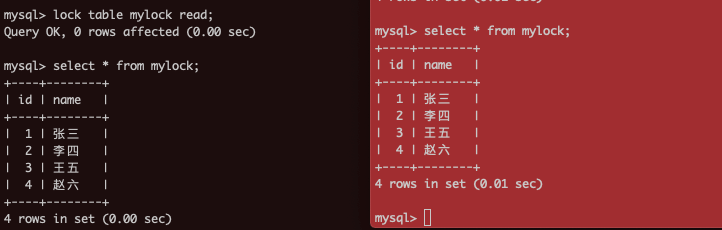

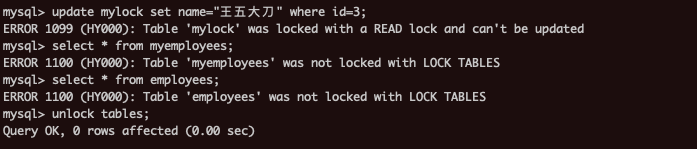

我们发现黑色终端对mylock这个资源加了读锁，那么在mylock这个表的读锁释放之前，黑终端和其他终端都不能对这个表资源做任何更新操作。仔细想想，这也是正常的，读锁说明这个资源只能被读，任何更新操作都不允许(其他终端的更新操作需要等待，本终端的因为知道这把锁是读锁，所以直接报错了)。除此之外，我们还发现，在黑色终端里想要查询别的表的数据，此时是禁止的,只有释放锁才能进行别的表的select。个人的理解: myisam进行select等操作默认需要获取锁，对于同一把读锁，可以多次acquire。但是在获得一把锁的还未释放的同时，去获取另一把锁，则可能造成死锁，所以myisam对这种操作直接禁止了。

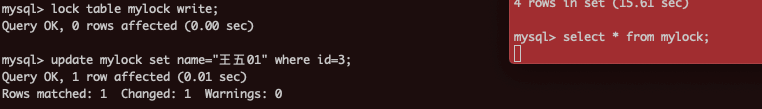

对表加写锁：黑色终端可以对加写锁的表又读又写好不畅快，其他终端(线程)只能干瞪眼，对这张表的所有操作都等(等待获取锁，写锁只能acquire一次，所以这里的select都不能操作)。同样，黑色终端在释放锁之前不能对别的表进行读写操作。

对MyISAM表进行操作,会有以下情况:
1. 对MyISAM表的读操作(加读锁) ,不会阻塞其他进程对同一表的读请求,但会阻塞对同一表的写请求。只有当读锁 释放后,才会执行其它进程的写操作。
2. 对MyISAM表的写操作(加写锁) ,会阻塞其他进程对同一表的读和写操作,只有当写锁释放后,才会执行其它进程的 读写操
简而言之,就是读锁会阻塞写,但是不会堵塞读。而写锁则会把读和写都堵塞

其实，无论是写锁还是读锁，本质上都是锁，只不过加了读和写这样的一层属性。



In [11]:
# 查看表锁的整体情况
%sql show status like 'table%';

 * mysql+pymysql://root@localhost/myemployees
5 rows affected.


[('Table_locks_immediate', '27'),
 ('Table_locks_waited', '0'),
 ('Table_open_cache_hits', '71'),
 ('Table_open_cache_misses', '22'),
 ('Table_open_cache_overflows', '0')]

* Table_locks_waited: 出现表级锁竞争而产生等待的个数，每等待一次值就加1，此值偏高说明竞争很多.
* Table_locks_immediate: 表示表级锁定的次数，表示可以立即获取锁的查询次数，每立即获取锁值就加1.

## InnoDB行级锁和表级锁

InnoDB与MyISAM的最大不同有两点:一是支持事务，而是采用了行级锁。

InnoDB 实现了以下两种类型的行锁：

* 共享锁（S）：允许一个事务去读一行，阻止其他事务获得相同数据集的排他锁。
* 排他锁（X）：允许获得排他锁的事务更新数据，阻止其他事务取得相同数据集的共享读锁和排他写锁。

为了允许行锁和表锁共存，实现多粒度锁机制，InnoDB 还有两种内部使用的意向锁（Intention Locks），这两种意向锁都是表锁：

* 意向共享锁（IS）：事务打算给数据行加行共享锁，事务在给一个数据行加共享锁前必须先取得该表的 IS 锁。
* 意向排他锁（IX）：事务打算给数据行加行排他锁，事务在给一个数据行加排他锁前必须先取得该表的 IX 锁。

意向锁的补充说明：

在mysql中有表锁，LOCK TABLE my_tabl_name READ;  用读锁锁表，会阻塞其他事务修改表数据。LOCK TABLE my_table_name WRITe; 用写锁锁表，会阻塞其他事务读和写。

innodb两种类型的锁共存的问题考虑这个例子：事务A锁住了表中的一行，让这一行只能读，不能写。之后，事务B申请整个表的写锁。如果事务B申请成功，那么理论上它就能修改表中的任意一行，这与A持有的行锁是冲突的。数据库需要避免这种冲突，就是说要让B的申请被阻塞，直到A释放了行锁。数据库要怎么判断这个冲突呢？

step1：判断表是否已被其他事务用表锁锁表

step2：判断表中的每一行是否已被行锁锁住。

注意step2，这样的判断方法效率实在不高，因为需要遍历整个表。于是就有了意向锁。

在意向锁存在的情况下，事务A必须<font color="red">先申请表的意向共享锁，成功后再申请一行的行锁</font>。在意向锁存在的情况下，上面的判断可以改成:

step1：不变

step2：发现表上有意向共享锁，说明表中有些行被共享行锁锁住了. 

因此，事务B申请表的写锁会被阻塞。注意：申请意向锁的动作是数据库完成的，就是说，事务A申请一行的行锁的时候，数据库会自动先开始申请表的意向锁，不需要我们程序员使用代码来申请。

### InnoDB加锁方法

* 意向锁是 InnoDB 自动加的， 不需用户干预。
* 对于 UPDATE、 DELETE 和 INSERT 语句， InnoDB会自动给涉及数据集加排他锁（X)；
* 对于普通 SELECT 语句，InnoDB 不会加任何锁；

事务可以通过以下语句显式给记录集加共享锁或排他锁：
1. 共享锁（S）：SELECT * FROM table_name WHERE ... LOCK IN SHARE MODE。 其他 session 仍然可以查询记录，并也可以对该记录加 share mode 的共享锁。但是如果当前事务需要对该记录进行更新操作，则很有可能造成死锁。
2. 排他锁（X)：SELECT * FROM table_name WHERE ... FOR UPDATE。其他 session 可以查询该记录，但是不能对该记录加共享锁或排他锁，而是等待获得锁

mysql有一个autocommit参数，默认是on，他的作用是每一条单独的查询都是一个事务，并且自动开始，自动提交（执行完以后就自动结束了，如果你要使用select for update，而不手动调用 start transaction，这个for update的行锁机制等于没用，因为行锁在自动提交后就释放了）. 所以，一般为了看行锁的效果，都是关闭autocommit并在一个事务中去执行。

#### 隐式锁定

InnoDB在事务执行过程中，使用两阶段锁协议：

随时都可以执行锁定，InnoDB会根据隔离级别在需要的时候自动加锁；

锁只有在执行commit或者rollback的时候才会释放，并且所有的锁都是在同一时刻被释放。

In [14]:
# 修改表的存储引擎为innodb
%sql ALTER TABLE mylock ENGINE=InnoDB;

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.


[]

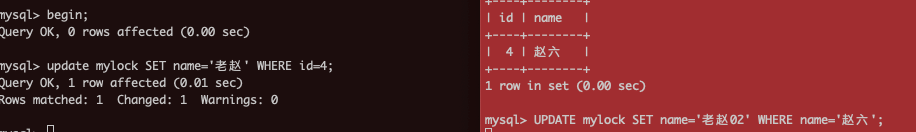

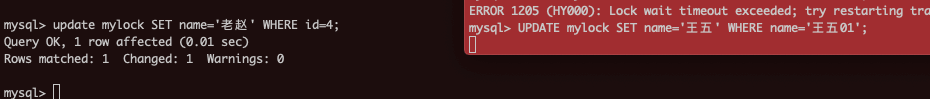

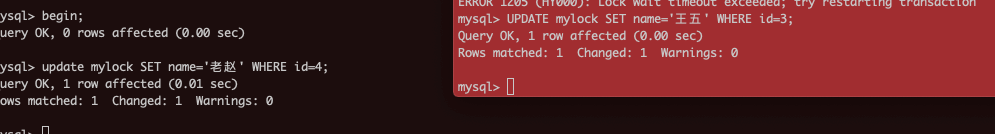

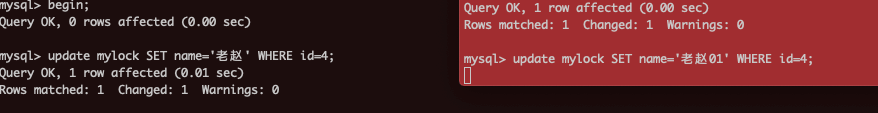

黑终端，在一个事务中执行了update mylock SET name='老赵' WHERE id=4语句，那么id=4的这条记录就被锁住了，其他终端不能对这条记录再进行修改，但是可以通过主键id去修改其他记录。另外，我们还发现通过name去修改其他记录被阻塞了, 这是因为<font color="red">只有通过索引条件检索数据，InnoDB 才使用行级锁，否则，InnoDB 将使用表锁！</font>.

<font color="red">再看一个索引失效行锁变表锁的例子</font>：

In [ ]:
%sql create index mylock_a on mylock(a);
%sql create index mylock_b on mylock(b);

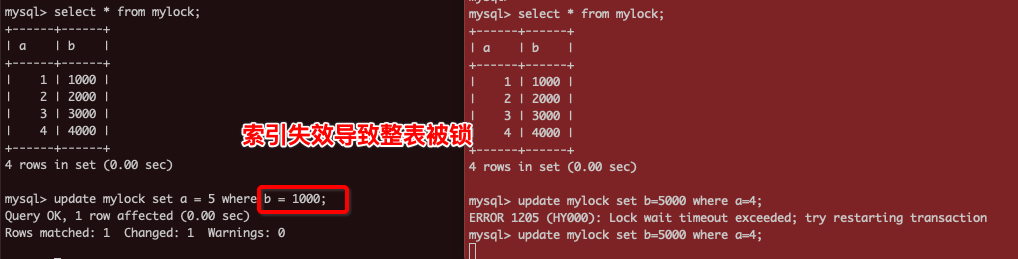

<font color="red">再看一个间隙锁危害的例子</font>：

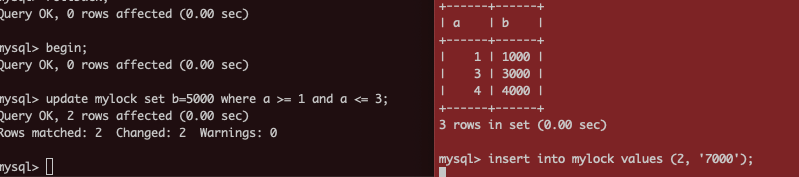
可以看到，黑色终端更新是a从1到3(包括间隙2)，红色终端阻塞了，不能插入a是2的记录。

#### 显式锁定

共享锁: select ... lock in share mode 

排他锁: select ... for update 

* select for update：

    在执行这个 select 查询语句的时候，会将对应的索引访问条目进行上排他锁（X 锁），也就是说这个语句对应的锁就相当于update带来的效果。

    使用场景：为了让自己查到的数据确保是最新数据，<font color="red">并且查到后的数据只允许自己来修改的时候</font>，需要用到 for update 子句。
* select lock in share mode
    将查找到的数据加上一个 share 锁，这个就是表示其他的事务只能对这些数据进行简单的select 操作，并不能够进行 DML 操作。
    使用场景：为了确保自己查到的数据没有被其他的事务正在修改，<font color="red">也就是说确保查到的数据是最新的数据，并且不允许其他人来修改数据。但是自己不一定能够修改数据，</font>因为有可能其他的事务也对这些数据 使用了 in share mode 的方式上了 S 锁。(如果其他事务没有加任何锁，那么当前事务还能修改本行数据,因为这属于当前事务获取排他锁，从这一点可以看出innodb的锁里还能嵌套锁，所以innodb可能会出现死锁的情况)
    
**性能影响**：
select for update 语句，相当于一个 update 语句。在业务繁忙的情况下，如果事务没有及时的commit或者rollback 可能会造成其他事务长时间的等待，从而影响数据库的并发使用效率。
select lock in share mode 语句是一个给查找的数据上一个共享锁（S 锁）的功能，它允许其他的事务也对该数据上S锁，但是不能够允许对该数据进行修改。如果不及时的commit 或者rollback 也可能会造成大量的事务等待。

**for update 和 lock in share mode 的区别**：

前一个上的是排他锁（X 锁），一旦一个事务获取了这个锁，其他的事务是没法在这些数据上执行 for update ；后一个是共享锁，多个事务可以同时的对相同数据执行 lock in share mode。


### innodb行锁注意事项

1. InnoDB 行锁是通过给索引上的索引项加锁来实现的，这一点 MySQL 与 Oracle 不同，后者是通过在数据块中对相应数据行加锁来实现的。InnoDB 这种行锁实现特点意味着：只有通过索引条件检索数据，InnoDB 才使用行级锁，否则，InnoDB 将使用表锁！也就是说，锁是加在索引字段上的。
2. 不论是使用主键索引、唯一索引或普通索引，InnoDB 都会使用行锁来对数据加锁。
3. 只有执行计划真正使用了索引，才能使用行锁：即便在条件中使用了索引字段，但是否使用索引来检索数据是由 MySQL 通过判断不同执行计划的代价来决定的，如果 MySQL 认为全表扫描效率更高，比如对一些很小的表，它就不会使用索引，这种情况下 InnoDB 将使用表锁，而不是行锁。因此，在分析锁冲突时，别忘了检查 SQL 的执行计划（可以通过 explain 检查 SQL 的执行计划），以确认是否真正使用了索引
4. 检索值的数据类型与索引字段不同，虽然MySQL能够进行数据类型转换，但却不会使用索引，从而导致InnoDB使用表锁。

## 乐观锁、悲观锁

* 乐观锁(Optimistic Lock)：假设不会发生并发冲突，只在提交操作时检查是否违反数据完整性。 乐观锁不能解决脏读的问题。

    乐观锁, 顾名思义，就是很乐观，每次去拿数据的时候都认为别人不会修改，所以不会上锁，但是在更新的时候会判断一下在此期间别人有没有去更新这个数据
* 悲观锁(Pessimistic Lock)：假定会发生并发冲突，屏蔽一切可能违反数据完整性的操作。

    悲观锁，顾名思义，就是很悲观，每次去拿数据的时候都认为别人会修改，所以每次在拿数据的时候都会上锁，这样别人想拿这个数据就会block直到它拿到锁。传统的关系型数据库里边就用到了很多这种锁机制，比如行锁，表锁等，读锁，写锁等，都是在做操作之前先上锁。


假设有A、B两个用户同时各购买一件 id=1 的商品，用户A获取到的库存量为 1000，用户B获取到的库存量也为 1000，用户A完成购买后修改该商品的库存量为 999，用户B完成购买后修改该商品的库存量为 999，此时库存量数据产生了不一致。

有两种解决方案：

悲观锁方案：每次获取商品时，对该商品加排他锁。也就是在用户A获取获取 id=1 的商品信息时对该行记录加锁，期间其他用户阻塞等待访问该记录。悲观锁适合写入频繁的场景。
```
begin;
select * from goods where id = 1 for update;
update goods set stock = stock - 1 where id = 1;
commit;
```
乐观锁方案：每次获取商品时，不对该商品加锁。在更新数据的时候需要比较程序中的库存量与数据库中的库存量是否相等，如果相等则进行更新，反之程序重新获取库存量，再次进行比较，直到两个库存量的数值相等才进行数据更新。乐观锁适合读取频繁的场景。
```
#不加锁获取 id=1 的商品对象
select * from goods where id = 1

begin;
#更新 stock 值，这里需要注意 where 条件 "stock = cur_stock"，只有程序中获取到的库存量与数据库中的库存量相等才执行更新
update goods set stock = stock - 1 where id = 1 and stock = cur_stock;
commit;
```
如果我们需要设计一个商城系统，该选择以上的哪种方案呢？

查询商品的频率比下单支付的频次高，基于以上我可能会优先考虑第二种方案
